In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.simple_grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.simple_grammar.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.simple_grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.simple_grammar.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.simple_grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cups:Cole_Hardware_

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/
Meshcat url:  http://127.0.0.1:7007/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"
#DATASET_YAML_FILE = "sink/saved_outlier_scenes.yaml"
#DATASET_SAVE_FILE = "observed_outlier_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "bin": DishBin
    }
    model_map = {
    }
    for model_type_set in [PlateModels, CupModels, BowlModels]:
        for model_type in model_type_set:
            # Have to cut off the "sink" folder to match model names;
            # dataset management is ugly and should get reorganized...
            model_map[os.path.join(*model_type.sdf.split("/")[1:])] = model_type
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map, model_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

[2021-10-06 14:44:43.459] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Saving...
Loading...


In [4]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [5]:
em = EMWrapper(grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (AssortedBowls): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue): None
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose): None
    (AssortedCups): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (AssortedPlates): ConstrainedParameter()
    (Plate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise): None
    (Cup): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20

In [6]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_simple_grammar.torch")

In [9]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_simple_grammar.torch"))

<All keys matched successfully>

Final params:  tensor([0.7667, 0.7667, 0.6000])


AssertionError: 

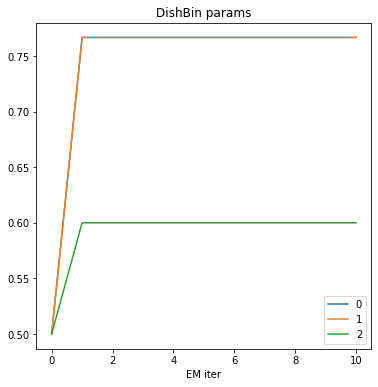

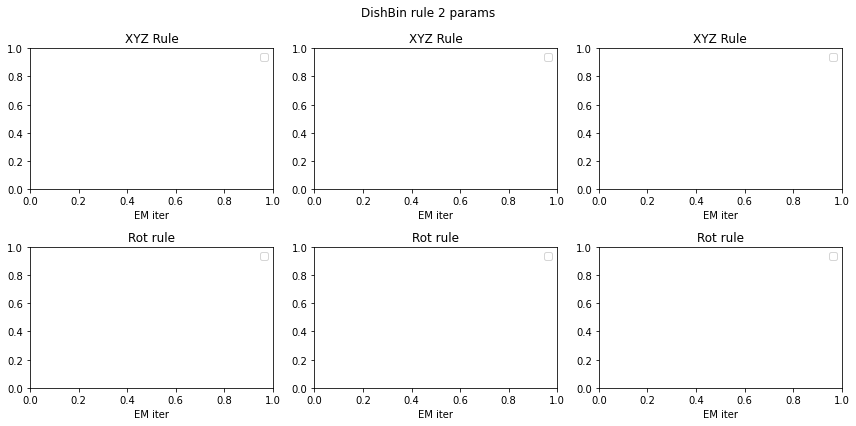

In [10]:
em.plot_grammar_parameter_history(DishBin)
em.plot_grammar_parameter_history(Object)
print("Plate")
em.plot_grammar_parameter_history(Plate)

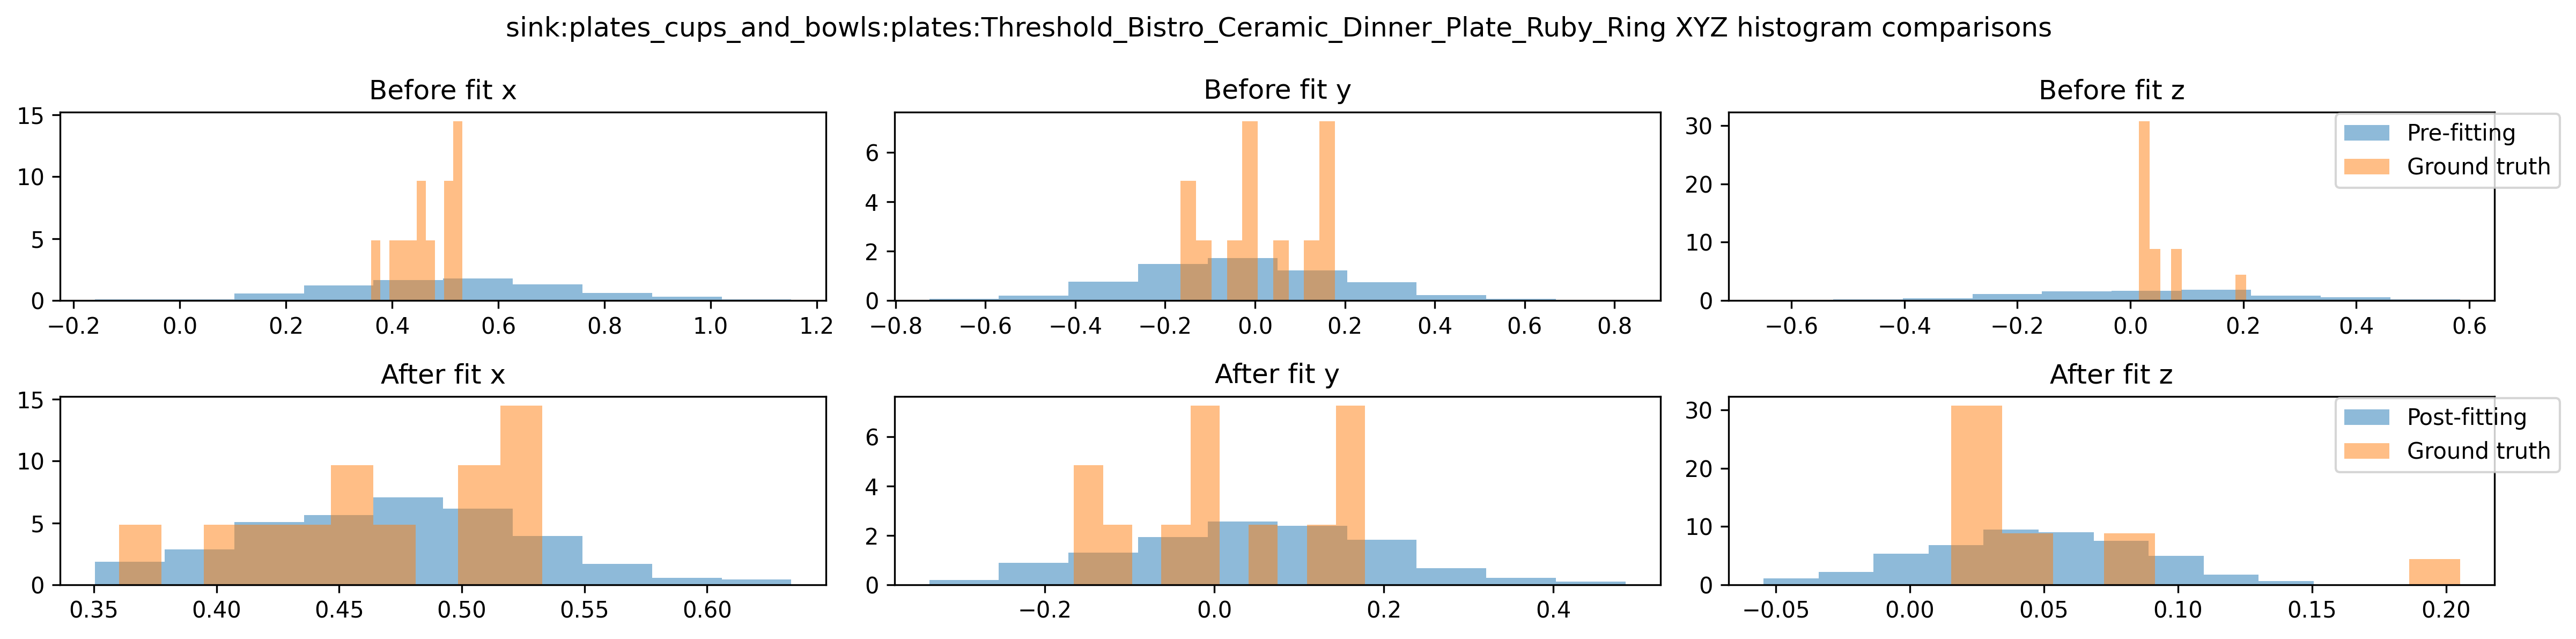

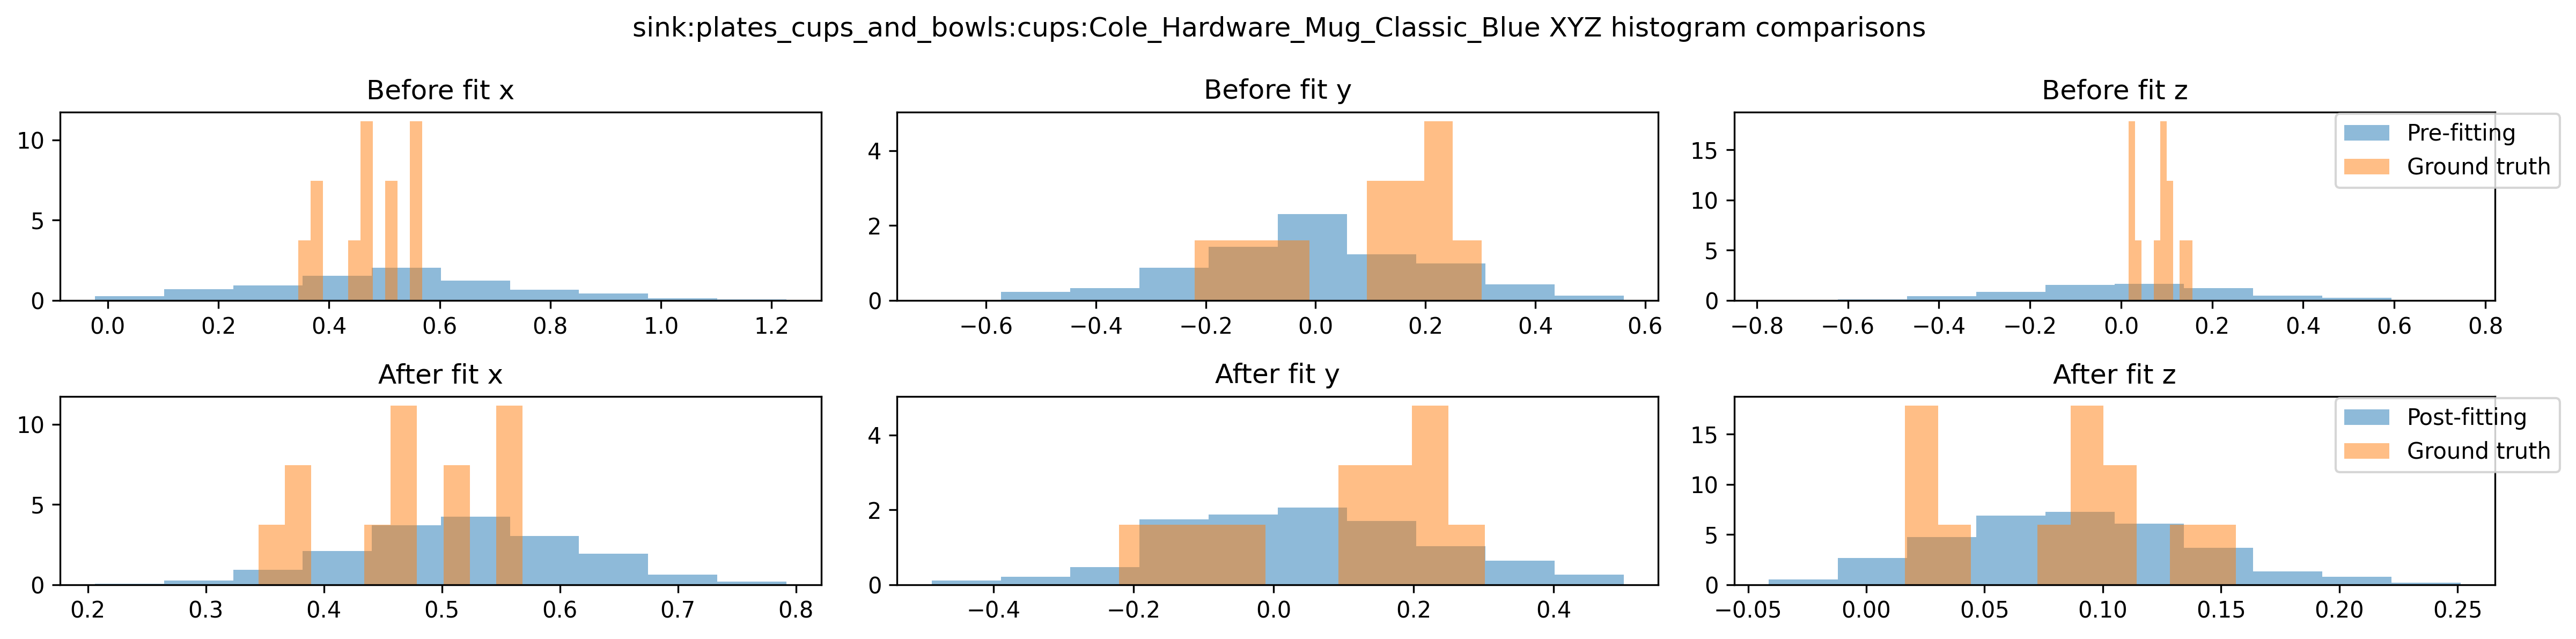

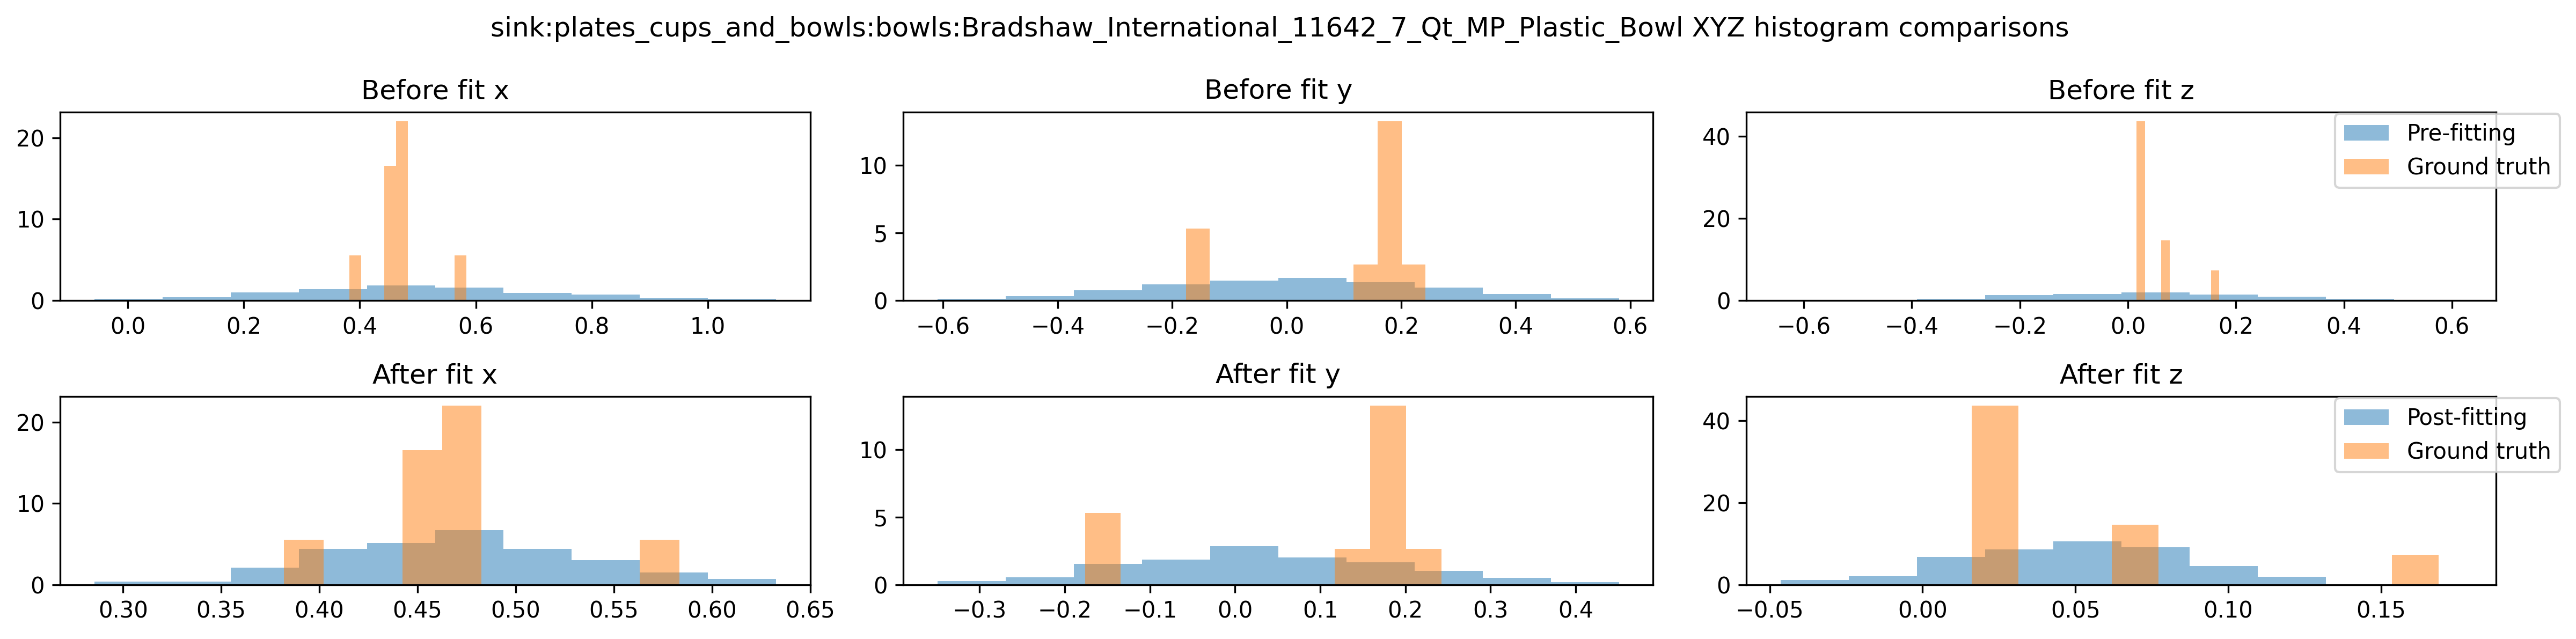

In [11]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)